In [1]:
from google.colab import files
uploaded = files.upload()

Saving bank_customers_large.csv to bank_customers_large.csv


In [3]:
import pandas as pd

In [5]:
df = pd.read_csv('bank_customers_large.csv')

In [6]:
df.head()

,customer_id,age,monthly_income,avg_account_balance,transactions_per_month,credit_card_spend,loan_status,days_since_last_txn
0,C00001,59,118071,709537,75,169449,No Loan,152
1,C00002,49,199971,921978,75,445581,No Loan,126
2,C00003,35,161842,1305987,49,365556,Personal Loan,115
3,C00004,63,190393,721861,2,296695,Home Loan,148
4,C00005,28,129863,558188,67,305070,Home Loan,67


In [7]:
df.describe()

,age,monthly_income,avg_account_balance,transactions_per_month,credit_card_spend,days_since_last_txn
count,5500.000000,5500.000000,5.500000e+03,5500.000000,5500.000000,5500.000000
mean,42.530909,109592.698545,1.010004e+06,40.029455,249772.623091,89.539636
std,12.563653,51680.279642,5.729614e+05,22.933228,144839.751983,51.827677
min,21.000000,20028.000000,5.064000e+03,1.000000,56.000000,0.000000
25%,32.000000,64553.250000,5.184260e+05,20.000000,124811.000000,44.000000
50%,43.000000,109755.500000,1.012752e+06,40.000000,250128.500000,89.000000
75%,53.000000,154374.750000,1.506070e+06,60.000000,372584.000000,134.000000
max,64.000000,199971.000000,1.999933e+06,79.000000,499845.000000,179.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   customer_id             5500 non-null   object
 1   age                     5500 non-null   int64 
 2   monthly_income          5500 non-null   int64 
 3   avg_account_balance     5500 non-null   int64 
 4   transactions_per_month  5500 non-null   int64 
 5   credit_card_spend       5500 non-null   int64 
 6   loan_status             5500 non-null   object
 7   days_since_last_txn     5500 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 343.9+ KB


In [8]:
df.isnull().sum()

,0
customer_id,0
age,0
monthly_income,0
avg_account_balance,0
transactions_per_month,0
credit_card_spend,0
loan_status,0
days_since_last_txn,0


**🔹 STEP 1: Feature Engineering**

Convert raw data → behavioral signals

In [11]:
import numpy as np

# Activity Score (how active a customer is)
df['activity_score'] = (
    df['transactions_per_month'] / df['transactions_per_month'].max()
)

# Spend Intensity (how much they spend relative to income)
df['spend_intensity'] = df['credit_card_spend'] / df['monthly_income']

# Credit Usage Ratio (credit spend vs balance)
df['credit_usage_ratio'] = df['credit_card_spend'] / (df['avg_account_balance'] + 1)

# Dormancy Flag (1 = dormant, 0 = active)
df['dormancy_flag'] = np.where(df['days_since_last_txn'] > 90, 1, 0)

df.head()


,customer_id,age,monthly_income,avg_account_balance,transactions_per_month,credit_card_spend,loan_status,days_since_last_txn,activity_score,spend_intensity,credit_usage_ratio,dormancy_flag
0,C00001,59,118071,709537,75,169449,No Loan,152,0.949367,1.435145,0.238816,1
1,C00002,49,199971,921978,75,445581,No Loan,126,0.949367,2.228228,0.483288,1
2,C00003,35,161842,1305987,49,365556,Personal Loan,115,0.620253,2.258721,0.279908,1
3,C00004,63,190393,721861,2,296695,Home Loan,148,0.025316,1.558329,0.411013,1
4,C00005,28,129863,558188,67,305070,Home Loan,67,0.848101,2.349168,0.546535,0


**🔹 STEP 2: Data Preprocessing**

2.1 Handle Missing Values

In [12]:
df.fillna(0, inplace=True)


2.2 Encode Categorical Variable

In [13]:
df_encoded = pd.get_dummies(df, columns=['loan_status'], drop_first=True)


2.3 Select Features for Modeling

In [14]:
features = [
    'monthly_income',
    'avg_account_balance',
    'transactions_per_month',
    'credit_card_spend',
    'activity_score',
    'spend_intensity',
    'credit_usage_ratio',
    'dormancy_flag'
]

X = df_encoded[features]


2.4 Normalize Features

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


2.5 Outlier Handling (IQR method – light touch)


In [16]:
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

X = X[~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)]


**🔹 STEP 3: Customer Segmentation (K-Means)**

3.1 Elbow Method

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 8), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


3.2 Apply K-Means

In [18]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
df['segment'] = kmeans.fit_predict(X_scaled)


**🔹 STEP 4: Segment Profiling**

In [19]:
segment_profile = df.groupby('segment').agg({
    'avg_account_balance': 'mean',
    'credit_card_spend': 'mean',
    'transactions_per_month': 'mean',
    'monthly_income': 'mean',
    'dormancy_flag': 'mean'
}).round(2)

segment_profile


,avg_account_balance,credit_card_spend,transactions_per_month,monthly_income,dormancy_flag
segment,,,,,
0,975735.38,357258.06,21.43,137055.87,0.46
1,1011018.51,233358.53,62.54,120745.98,0.50
2,1040007.84,372667.65,39.54,42341.96,0.50
3,23803.11,355969.86,43.27,111173.27,0.56
4,1068087.20,108384.82,22.90,103862.50,0.51


**🔹 STEP 5: Rule-Based Offer Recommendation**

5.1 Define Segment Names (Manual Mapping)

In [20]:
segment_mapping = {
    0: 'High-Value Active',
    1: 'Salary Low Spend',
    2: 'Dormant',
    3: 'High Spend Risk',
    4: 'Young Earners'
}

df['segment_label'] = df['segment'].map(segment_mapping)


5.2 Offer Recommendation Function

In [21]:
def recommend_offer(segment):
    if segment == 'High-Value Active':
        return 'Premium Credit Card & Relationship Manager'
    elif segment == 'Salary Low Spend':
        return 'Cashback & Spend-Based Offers'
    elif segment == 'Dormant':
        return 'Reactivation Campaign'
    elif segment == 'High Spend Risk':
        return 'Credit Limit Monitoring'
    elif segment == 'Young Earners':
        return 'Entry-Level Cards & Savings Plans'
    else:
        return 'Standard Banking Services'

df['recommended_offer'] = df['segment_label'].apply(recommend_offer)


**🔹 STEP 6: Dashboard & Insights**

Segment Distribution


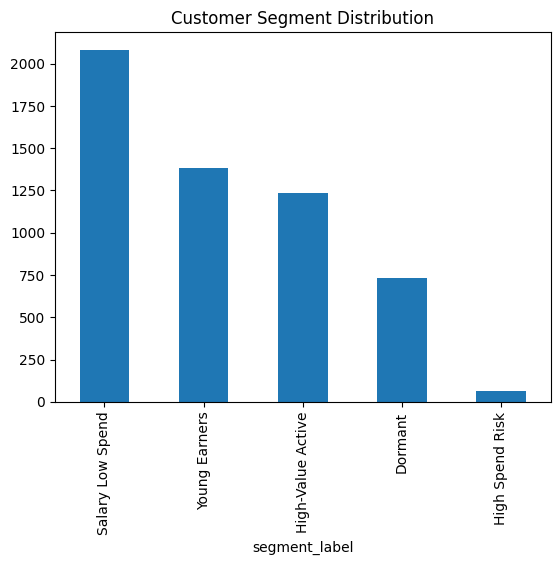

In [26]:
import matplotlib.pyplot as plt
df['segment_label'].value_counts().plot(kind='bar', title='Customer Segment Distribution')
plt.show()


Revenue Potential by Segment


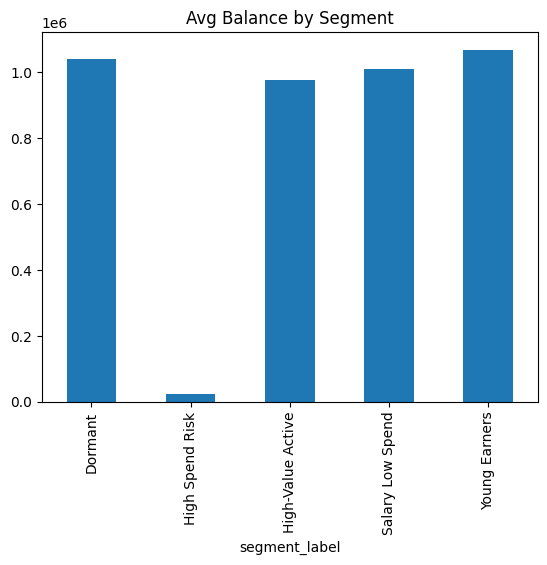

In [27]:
df.groupby('segment_label')['avg_account_balance'].mean().plot(
    kind='bar', title='Avg Balance by Segment'
)
plt.show()


Offer Count

In [24]:
df['recommended_offer'].value_counts()


,count
recommended_offer,
Cashback & Spend-Based Offers,2082
Entry-Level Cards & Savings Plans,1384
Premium Credit Card & Relationship Manager,1237
Reactivation Campaign,734
Credit Limit Monitoring,63


**🔹 STEP 7: Final Output (Export)**

In [25]:
final_df = df[['customer_id', 'segment_label', 'recommended_offer']]
final_df.to_csv('final_customer_segments_with_offers.csv', index=False)

final_df.head()


,customer_id,segment_label,recommended_offer
0,C00001,Salary Low Spend,Cashback & Spend-Based Offers
1,C00002,Salary Low Spend,Cashback & Spend-Based Offers
2,C00003,Salary Low Spend,Cashback & Spend-Based Offers
3,C00004,High-Value Active,Premium Credit Card & Relationship Manager
4,C00005,Salary Low Spend,Cashback & Spend-Based Offers
